In [187]:
import torch
from SVI_solver_library.transform.AdapterTransform import AdapterTransform as Adapter
from SVI_solver_library.solver.ProjSolver import ProjSolver as ProjSolver

In [188]:
def P_X(u, l, h):
    return torch.where(u < l, l, torch.where(u > h, h, u))

In [189]:
def P_ex(u):
    return P_X(u, torch.tensor([1, 0, 0, 1], dtype=torch.double), 100)

In [190]:
def F_ex(u):
    return torch.tensor([3*u[0] - 1/(u[0] + 0.1) + 3*u[1] - 2,
                  3*u[0] + 3 * u[1],
                  4*u[2] + 3*u[3],
                  4*u[2] + 4*u[3] - 1 / (u[3] + 0.1) - 3],dtype=torch.double)

In [191]:
F = Adapter(F_ex)
P = Adapter(P_ex)
Ex_solver = ProjSolver(F, torch.tensor([4, 4, 4, 4], dtype=torch.double), P = P)
u_ex = torch.rand(4, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [192]:
import matplotlib.pyplot as plt
import numpy as np

In [193]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

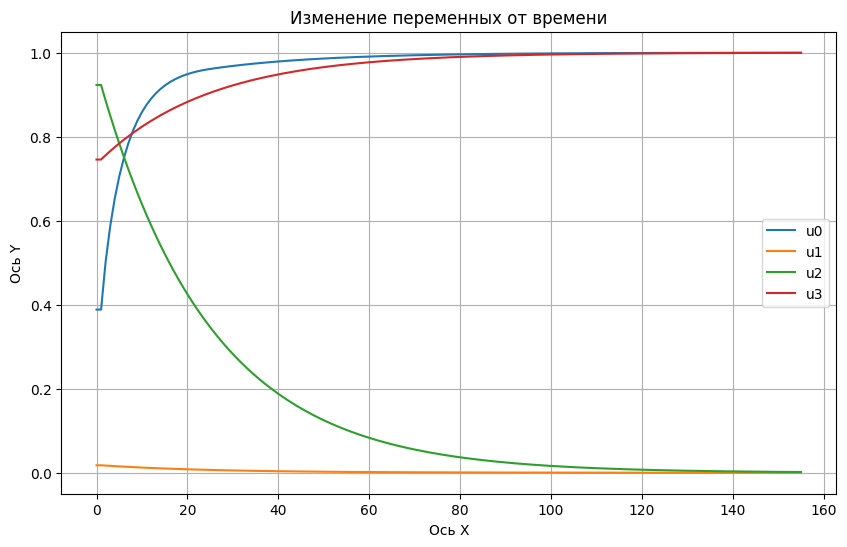

In [194]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()

In [195]:
def project(x, C):
    norm = np.linalg.norm(x)
    if norm > 1:
        return x / norm
    return x

In [196]:
def P_ex1(u):
    return project(u, 1)

In [197]:
def F_ex1(u):
    return 4*u**3 - 4*u

In [198]:
F_1 = Adapter(F_ex1)
P_1 = Adapter(P_ex1)
Ex_solver = ProjSolver(F_1, torch.tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=torch.double), P = P_1)
u_ex = torch.rand(10, dtype=torch.double)
answer, verbose = Ex_solver.solve(u_ex)

In [199]:
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

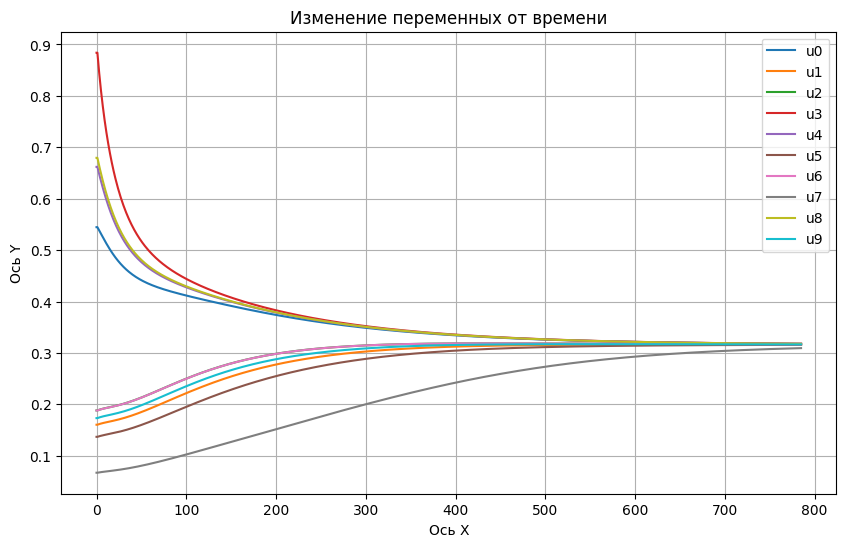

In [200]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='u0')  
plt.plot(u1_history.numpy(), label='u1')  
plt.plot(u2_history.numpy(), label='u2') 
plt.plot(u3_history.numpy(), label='u3') 
plt.plot(u4_history.numpy(), label='u4') 
plt.plot(u5_history.numpy(), label='u5') 
plt.plot(u6_history.numpy(), label='u6') 
plt.plot(u7_history.numpy(), label='u7') 
plt.plot(u8_history.numpy(), label='u8') 
plt.plot(u9_history.numpy(), label='u9') 


plt.title('Изменение переменных от времени')
plt.xlabel('Ось X')
plt.ylabel('Ось Y')
plt.legend()
plt.grid(True) 

plt.show()

In [201]:
answer

tensor([0.3177, 0.3163, 0.3167, 0.3178, 0.3177, 0.3157, 0.3167, 0.3094, 0.3177,
        0.3165], dtype=torch.float64)

In [202]:
import numpy as np
import time

def f(x):
    return np.sum(x**4 - 2*x**2)

def G(x):
    return 4*x**3 - 4*x

def J(x):
    return np.diag(12*x**2 - 4)

def project(x, C):
    norm = np.linalg.norm(x)
    if norm > C:
        return x / norm
    return x

def variational_inequality(G, x, C, max_iter=1000, tol=1e-5):
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        x_new = project(x - G(x), C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def newton_method(G, J, x0, C, max_iter=1000, tol=1e-10):
    x = x0
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        J_inv = np.linalg.inv(J(x))
        dx = -np.dot(J_inv, G(x))
        x_new = project(x + dx, C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def extragradient_method(G, x0, C, learning_rate=0.1, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        y = project(x - learning_rate * G(x), C)
        x_new = project(x - learning_rate * G(y), C)
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

def phi_alpha(G, x, alpha, C):
    def Phi_alpha(x, y):
        return np.dot(G(x), x - y) - (1 / (2 * alpha)) * np.linalg.norm(x - y)**2

    def y_alpha(x):
        y = x - alpha * G(x)
        norm_y = np.linalg.norm(y)
        if norm_y > C:
            y = y / norm_y
        return y

    y_alpha_x = y_alpha(x)
    return Phi_alpha(x, y_alpha_x)

def interval_descent(G, J, x0, alpha, beta, gamma, C, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    for k in range(max_iter):
        iter_count += 1
        y_alpha_x = x - alpha * G(x)
        norm_y = np.linalg.norm(y_alpha_x)
        if norm_y > C:
            y_alpha_x = y_alpha_x / norm_y
        dk = y_alpha_x - x
        if np.linalg.norm(dk) < tol:
            break
        m = 1
        while phi_alpha(G, x + gamma**m * dk, alpha, C) > phi_alpha(G, x, alpha, C) - beta * gamma**m * np.linalg.norm(dk)**2 and m < 2:
            m += 1
        lambda_k = gamma**m
        x = x + lambda_k * dk
    return x, iter_count


n = 2  # Размерность задачи
x0 = np.random.rand(n)
C = 1  # Радиус шара
alpha = 0.1
beta = 0.5
gamma = 0.5

# Проективный метод
start_time = time.time()
solution_proj, iter_count_proj = variational_inequality(G, x0, C)
proj_time = time.time() - start_time

# Метод Ньютона
start_time = time.time()
solution_newton, iter_count_newton = newton_method(G, J, x0, C)
newton_time = time.time() - start_time

# Экстраградиентный метод
start_time = time.time()
solution_extra, iter_count_extra = extragradient_method(G, x0, C)
extra_time = time.time() - start_time

# Метод спуска по интервальной функции
start_time = time.time()
solution_interval, iter_count_interval = interval_descent(G, J, x0, alpha, beta, gamma, C)
interval_time = time.time() - start_time

start_time = time.time()
Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1))
u_ex = torch.rand(n, dtype=torch.double)
solution_solver= Ex_solver.solve(u_ex)
solver_time = time.time() - start_time

# Вывод результатов
print(f"Проективный метод: Время выполнения = {proj_time:.5f} сек, Количество итераций = {iter_count_proj}, Решение = {solution_proj}, Значение = {f(solution_proj)}")
print(f"Метод Ньютона: Время выполнения = {newton_time:.5f} сек, Количество итераций = {iter_count_newton}, Решение = {solution_newton}, Значение = {f(solution_newton)}")
print(f"Экстраградиентный метод: Время выполнения = {extra_time:.5f} сек, Количество итераций = {iter_count_extra}, Решение = {solution_extra}, Значение = {f(solution_extra)}")
print(f"Метод спуска по интервальной функции: Время выполнения = {interval_time:.5f} сек, Количество итераций = {iter_count_interval}, Решение = {solution_interval}, Значение = {f(solution_interval)}")
print(f"Метод нейронной сети: Время выполнения = {solver_time:.5f} сек, Решение = {solution_solver[0]}, Значение = {f(solution_solver[0].detach().numpy())}")

Проективный метод: Время выполнения = 0.00000 сек, Количество итераций = 10, Решение = [0.70710291 0.70711066], Значение = -1.4999999999399523
Метод Ньютона: Время выполнения = 0.00000 сек, Количество итераций = 4, Решение = [0. 1.], Значение = -1.0
Экстраградиентный метод: Время выполнения = 0.00100 сек, Количество итераций = 35, Решение = [0.70708654 0.70712702], Значение = -1.4999999983612355
Метод спуска по интервальной функции: Время выполнения = 0.00500 сек, Количество итераций = 75, Решение = [0.70708864 0.70712492], Значение = -1.4999999985891543
Метод нейронной сети: Время выполнения = 0.02000 сек, Решение = tensor([0.7053, 0.7066], dtype=torch.float64), Значение = -1.4967078603059156


In [203]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

integrator = EulerIntegrator(dt=0.1, max_iter=200, max_dif=0.001)

In [204]:
def test(n, results_dict):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)
    C = 1  # Радиус шара
    alpha = 0.1
    beta = 0.5
    gamma = 0.5

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj = variational_inequality(G, x0, C)
    proj_time = time.time() - start_time
    value_proj = f(solution_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(f(solution_proj))

    start_time = time.time()
    solution_newton, iter_count_newton = newton_method(G, J, x0, C)
    newton_time = time.time() - start_time
    value_newton = f(solution_newton)
    values.append(value_newton)
    iters_newton.append(iter_count_newton)
    times_newton.append(newton_time)
    solutions_newton.append(f(solution_newton))

    start_time = time.time()
    solution_extra, iter_count_extra = extragradient_method(G, x0, C)
    extra_time = time.time() - start_time
    value_extra = f(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(f(solution_extra))

    start_time = time.time()
    solution_interval, iter_count_interval = interval_descent(G, J, x0, alpha, beta, gamma, C)
    value_interval = f(solution_interval)
    values.append(value_interval)
    interval_time = time.time() - start_time
    iters_interval.append(iter_count_interval)
    times_interval.append(interval_time)
    solutions_interval.append(f(solution_interval))


    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(f(solution_neuro.detach().numpy()))
    value_neuro = f(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Ньютон", solution_newton, value_newton, newton_time, iter_count_newton),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Интервальный спуск", solution_interval, value_interval, interval_time, iter_count_interval),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [205]:
import numpy as np
import time
import matplotlib.pyplot as plt

# ... (Your existing code for functions f, G, J, project, variational_inequality, etc.)
iters_proj = []
iters_newton = []
iters_extra = []
iters_interval = []
iters_neuro = []
times_proj = []
times_newton = []
times_extra = []
times_interval = []
times_neuro = []
solutions_proj = []
solutions_newton = []
solutions_extra = []
solutions_interval = []
solutions_neuro = []
verboses = []

results_dict = {'Имя метода': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(1, 11):
    test(n, results_dict)

In [206]:
verbose = verboses[9]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

In [207]:
verbose = verboses[1]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]

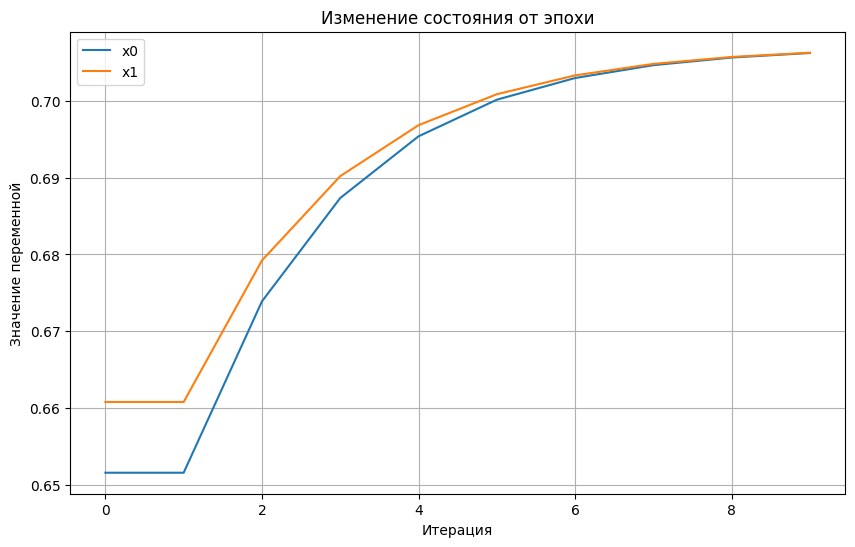

In [208]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [209]:
verbose = verboses[2]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]

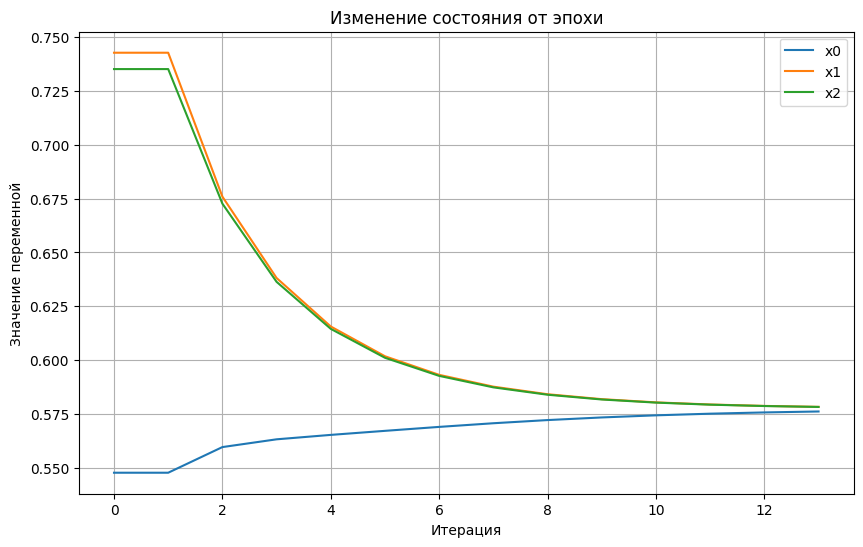

In [210]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [211]:
verbose = verboses[3]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]

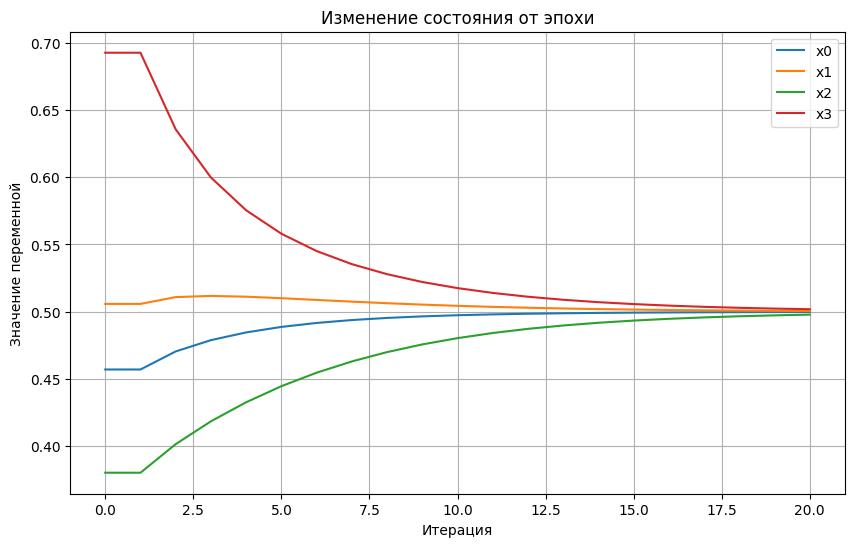

In [212]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2')  
plt.plot(u3_history.numpy(), label='x3')  


plt.title('Изменение состояния от эпохи')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [213]:
verbose = verboses[9]
u0_history = verbose[:, 0]
u1_history = verbose[:, 1]
u2_history = verbose[:, 2]
u3_history = verbose[:, 3]
u4_history = verbose[:, 4]
u5_history = verbose[:, 5]
u6_history = verbose[:, 6]
u7_history = verbose[:, 7]
u8_history = verbose[:, 8]
u9_history = verbose[:, 9]

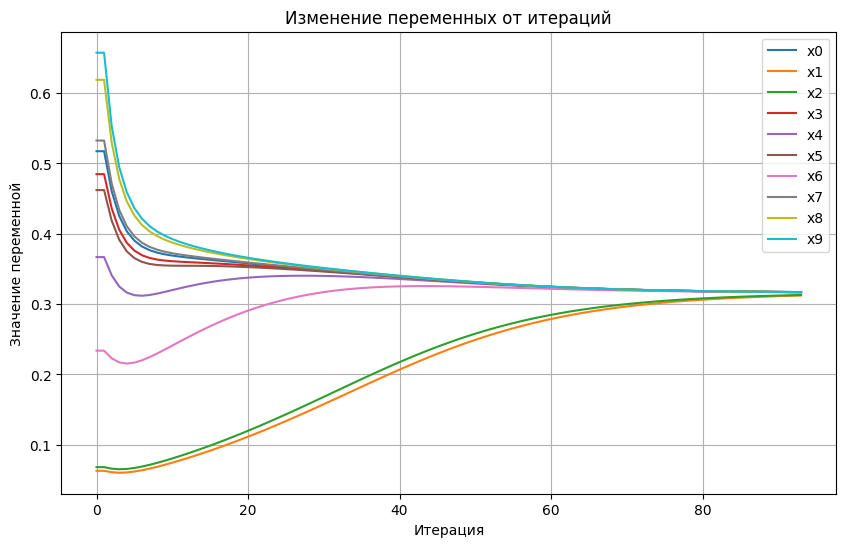

In [214]:
plt.figure(figsize=(10, 6)) 
plt.plot(u0_history.numpy(), label='x0')  
plt.plot(u1_history.numpy(), label='x1')  
plt.plot(u2_history.numpy(), label='x2') 
plt.plot(u3_history.numpy(), label='x3') 
plt.plot(u4_history.numpy(), label='x4') 
plt.plot(u5_history.numpy(), label='x5') 
plt.plot(u6_history.numpy(), label='x6') 
plt.plot(u7_history.numpy(), label='x7') 
plt.plot(u8_history.numpy(), label='x8') 
plt.plot(u9_history.numpy(), label='x9') 


plt.title('Изменение переменных от итераций')
plt.xlabel('Итерация')
plt.ylabel('Значение переменной')
plt.legend()
plt.grid(True) 

plt.show()

In [215]:
from IPython.display import display

In [216]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
grouped = results_df.groupby('Размерность')

# Пример: вывод сгруппированных данных
for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
0,Проекция,1,-1.000000,0.000000e+00,0.000000,2
1,Ньютон,1,-1.000000,0.000000e+00,0.000000,2
2,Экстраградиент,1,-1.000000,1.189244e-08,0.001000,45
3,Интервальный спуск,1,-1.000000,4.903387e-10,0.001000,24
4,Нейросетевой,1,-0.999992,8.368041e-06,0.002002,11


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
5,Проекция,2,-1.500000,0.000000e+00,0.000000,7
6,Ньютон,2,-1.000000,5.000000e-01,0.000000,6
7,Экстраградиент,2,-1.500000,1.828526e-09,0.000000,19
8,Интервальный спуск,2,-1.500000,1.337028e-09,0.001997,35
9,Нейросетевой,2,-1.498548,1.452374e-03,0.001004,10


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
10,Проекция,3,-1.666667,0.000587,0.000998,10
11,Ньютон,3,-1.000000,0.667254,0.000000,7
12,Экстраградиент,3,-1.666667,0.000587,0.000000,39
13,Интервальный спуск,3,-1.666667,0.000587,0.005000,95
14,Нейросетевой,3,-1.667254,0.000000,0.001999,14


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
15,Проекция,4,-1.75000,0.000000e+00,0.000000,15
16,Ньютон,4,-1.00000,7.500000e-01,0.000000,6
17,Экстраградиент,4,-1.75000,3.202135e-09,0.001001,48
18,Интервальный спуск,4,-1.75000,3.968403e-09,0.004999,115
19,Нейросетевой,4,-1.74999,9.813953e-06,0.003001,21


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
20,Проекция,5,-1.80000,0.000000e+00,0.000000,28
21,Ньютон,5,-1.00000,8.000000e-01,0.000999,6
22,Экстраградиент,5,-1.80000,3.700135e-09,0.001000,78
23,Интервальный спуск,5,-1.80000,4.725323e-09,0.010999,199
24,Нейросетевой,5,-1.79999,9.936157e-06,0.007003,46


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
25,Проекция,6,-1.833333,0.000000e+00,0.000000,33
26,Ньютон,6,-1.000000,8.333333e-01,0.000000,8
27,Экстраградиент,6,-1.833333,4.106885e-09,0.001997,87
28,Интервальный спуск,6,-1.833333,5.580011e-09,0.011003,218
29,Нейросетевой,6,-1.833319,1.392289e-05,0.006996,50


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
30,Проекция,7,-1.857143,0.000000e+00,0.000000,37
31,Ньютон,7,-1.000000,8.571429e-01,0.000000,5
32,Экстраградиент,7,-1.857143,4.921930e-09,0.002000,88
33,Интервальный спуск,7,-1.857143,7.381948e-09,0.008004,209
34,Нейросетевой,7,-1.857133,9.473988e-06,0.007996,52


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
35,Проекция,8,-1.87500,0.000000e+00,0.000000,42
36,Ньютон,8,-1.00000,8.750000e-01,0.000000,6
37,Экстраградиент,8,-1.87500,4.812548e-09,0.002002,105
38,Интервальный спуск,8,-1.87500,8.044166e-09,0.012000,265
39,Нейросетевой,8,-1.87499,9.922375e-06,0.008999,61


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
40,Проекция,9,-1.888889,0.000000e+00,0.000000,56
41,Ньютон,9,-1.000000,8.888889e-01,0.000000,6
42,Экстраградиент,9,-1.888889,6.157695e-09,0.002001,133
43,Интервальный спуск,9,-1.888889,9.286173e-09,0.019000,369
44,Нейросетевой,9,-1.888868,2.083724e-05,0.012000,83


,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
45,Проекция,10,-1.900000,0.000000e+00,0.000000,61
46,Ньютон,10,-1.000000,9.000000e-01,0.000000,7
47,Экстраградиент,10,-1.900000,6.580542e-09,0.003000,144
48,Интервальный спуск,10,-1.900000,1.003019e-08,0.023998,426
49,Нейросетевой,10,-1.899988,1.241815e-05,0.013002,94


In [217]:
result = results_df.groupby('Имя метода').mean().reset_index()

display(result)

,Имя метода,Размерность,Значение,Невязка,Время,Количество_итераций
0,Интервальный спуск,5.5,-1.707103,0.000059,0.0098,195.5
1,Нейросетевой,5.5,-1.707007,0.000155,0.0064,44.2
2,Ньютон,5.5,-1.000000,0.707162,0.0001,5.9
3,Проекция,5.5,-1.707103,0.000059,0.0001,29.1
4,Экстраградиент,5.5,-1.707103,0.000059,0.0014,78.6


Text(0, 0.5, 'Итерации')

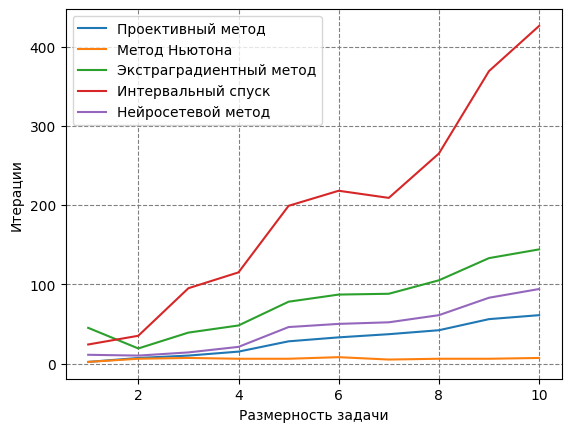

In [218]:
plt.grid(color='gray', linestyle='dashed')
plt.plot(range(1, 11), iters_proj, label='Проективный метод')
plt.plot(range(1, 11), iters_newton, label='Метод Ньютона')
plt.plot(range(1, 11), iters_extra, label='Экстраградиентный метод')
plt.plot(range(1, 11), iters_interval, label='Интервальный спуск')
plt.plot(range(1, 11), iters_neuro, label='Нейросетевой метод')
plt.legend()
plt.xlabel('Размерность задачи')
plt.ylabel('Итерации')

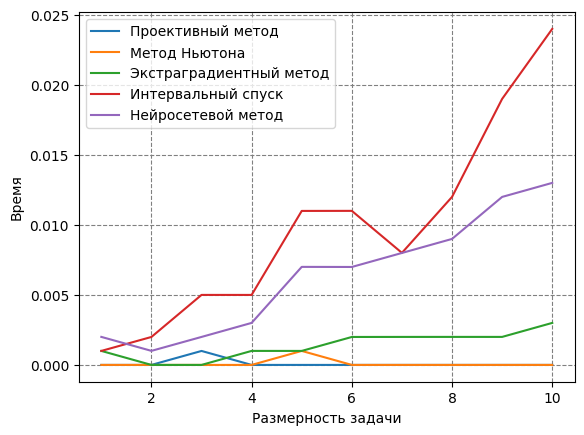

In [219]:
plt.grid(color='gray', linestyle='dashed')
plt.plot(range(1, 11), times_proj, label='Проективный метод')
plt.plot(range(1, 11), times_newton, label='Метод Ньютона')
plt.plot(range(1, 11), times_extra, label='Экстраградиентный метод')
plt.plot(range(1, 11), times_interval, label='Интервальный спуск')
plt.plot(range(1, 11), times_neuro, label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Время')
plt.legend(loc='upper left')

In [220]:
results_df['Невязка'] = results_df['Невязка'].astype(float)

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Невязка'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Невязка'].tolist()

print(residuals_list[0])

[4.903386585652925e-10, 1.3370284879243854e-09, 0.0005869184974640618, 3.968402939591442e-09, 4.725323465848419e-09, 5.580010675743097e-09, 7.38194838589834e-09, 8.044165555887162e-09, 9.286172941713744e-09, 1.0030192898469181e-08]


In [221]:
residuals

,Имя метода,Невязка
0,Интервальный спуск,"[4.903386585652925e-10, 1.3370284879243854e-09..."
1,Нейросетевой,"[8.368041283013383e-06, 0.0014523744466174993,..."
2,Ньютон,"[0.0, 0.4999999999532745, 0.6672535826251318, ..."
3,Проекция,"[0.0, 0.0, 0.0005869160588127809, 0.0, 0.0, 0...."
4,Экстраградиент,"[1.189244003274581e-08, 1.8285259972827816e-09..."


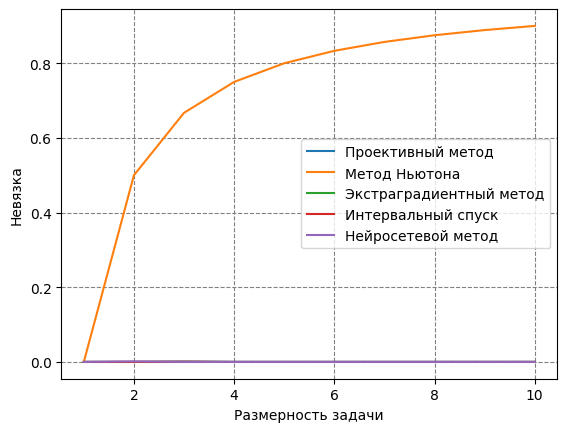

In [222]:
plt.rc('axes', axisbelow=True)
plt.plot(range(1, 11), residuals_list[3], label='Проективный метод')
plt.plot(range(1, 11), residuals_list[2], label='Метод Ньютона')
plt.plot(range(1, 11), residuals_list[4], label='Экстраградиентный метод')
plt.plot(range(1, 11), residuals_list[0], label='Интервальный спуск')
plt.plot(range(1, 11), residuals_list[1], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

# Функция Растригина

In [297]:
def rastrigin(x):
    """
    Функция Растригина
    
    Параметры:
    x -- массив numpy или список координат (может быть многомерным)
    
    Возвращает:
    Значение функции Растригина в точке x
    """
    A = 10
    n = len(x)
    return A * n + sum([(xi**2 - A * np.cos(2 * np.pi * xi)) for xi in x])

In [300]:
def P_X(u, l, h):
    return torch.where(u < l, l, torch.where(u > h, h, u))

def P_ex1(u):
    return P_X(u, -5.12, 5.12)

In [299]:
def P_X_numpy(u, l, h):
    return np.where(u < l, l, np.where(u > h, h, u))

In [301]:
def P_numpy(u):
    return P_X_numpy(u, -5.12, 5.12)

In [302]:
def G(x):
    A = 10
    return 2 * np.array(x) + 2 * np.pi * A * np.sin(2 * np.pi * np.array(x))

In [303]:
def variational_inequality(G, x, proj_func, learning_rate=0.1, max_iter=1000, tol=1e-5):
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        x_new = proj_func(x - learning_rate * G(x))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

In [304]:
def extragradient_method(G, x0, proj_func, learning_rate=0.1, max_iter=1000, tol=1e-5):
    x = x0
    iter_count = 0
    for _ in range(max_iter):
        iter_count += 1
        y = proj_func(x - learning_rate * G(x))
        x_new = proj_func(x - learning_rate * G(y))
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    return x, iter_count

In [305]:
def F_ex1(x):
    A = 10.0
    return 2 * x + 2 * torch.pi * A * torch.sin(2 * torch.pi * x)


In [231]:
P_numpy(np.array(0))

array(0.)

In [320]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = rastrigin(solution_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    value_extra = rastrigin(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = rastrigin(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [321]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
max_iter = 5000
learning_rate=1e-3
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(50, 200, 10):
    test_f(n, results_dict, max_iter, learning_rate)

In [323]:

results_df = pd.DataFrame(results_dict)
results_df['Невязка'] = results_df['Невязка'].astype(float)

# Группируем по методу и извлекаем значения невязки
residuals = results_df.groupby('Имя метода')['Невязка'].apply(list).reset_index()

# Преобразуем результат в список
residuals_list = residuals['Невязка'].tolist()

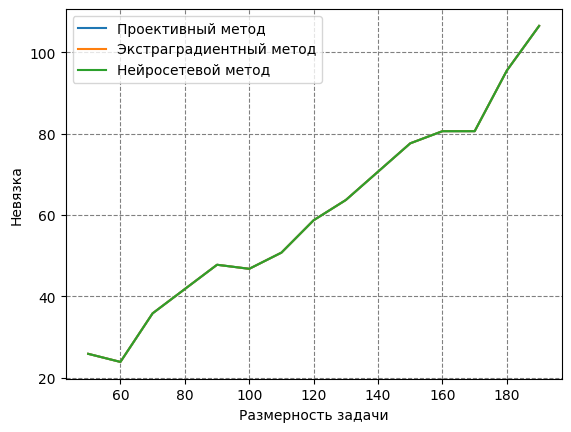

In [325]:
plt.rc('axes', axisbelow=True)
plt.plot(range(50, 200, 10), residuals_list[0], label='Проективный метод')
plt.plot(range(50, 200, 10), residuals_list[1], label='Экстраградиентный метод')
plt.plot(range(50, 200, 10), residuals_list[2], label='Нейросетевой метод')
plt.xlabel('Размерность задачи')
plt.ylabel('Невязка')
plt.legend()
plt.grid(color='gray', linestyle='dashed')

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
grouped = results_df.groupby('Размерность')

# Пример: вывод сгруппированных данных
for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,"[2.028524034247699e-07, 0.9949585885219175, 0....",50,24.873977,0.001002,31
1,Экстраградиент,"[3.5152328824528817e-06, 0.9949570871235904, 0...",50,24.873977,0.000999,43
2,Нейросетевой,"[-5.602073037530713e-09, 0.9949586377198942, 0...",50,24.873976,0.007093,42


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
3,Проекция,"[8.435870312225276e-09, 7.916610185436187e-09,...",60,30.843731,0.000000,36
4,Экстраградиент,"[1.1210248985721088e-06, 1.083119889091709e-06...",60,30.843731,0.000000,46
5,Нейросетевой,"[-3.16251132601935e-11, 1.4331727391262842e-10...",60,30.843731,0.009572,45


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
6,Проекция,"[0.994958624447774, 0.9949580229838697, 8.0172...",70,33.828608,0.000000,31
7,Экстраградиент,"[0.9949582556223738, 0.994954369874286, 1.6595...",70,33.828608,0.000998,44
8,Нейросетевой,"[0.9949586376527229, 0.9949585201396689, -2.19...",70,33.828608,0.001889,43


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
9,Проекция,"[0.99495858876726, 0.9949584990557552, 2.94490...",80,39.798362,0.000000,30
10,Экстраградиент,"[0.9949575962932591, 0.9949564510750437, 8.879...",80,39.798363,0.005762,43
11,Нейросетевой,"[0.9949586376587825, 0.9949586379214274, 6.260...",80,39.798362,0.004433,43


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
12,Проекция,"[0.9949586342368227, 4.8865948492123256e-08, 7...",90,42.783240,0.000000,33
13,Экстраградиент,"[0.9949584287339401, 1.6688541926477092e-06, 2...",90,42.783240,0.000000,45
14,Нейросетевой,"[0.9949586376519566, -5.612581794578864e-10, -...",90,42.783239,0.003011,44


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
15,Проекция,"[3.575785498292081e-08, 0.9949586189140194, 7....",100,44.773158,0.000000,37
16,Экстраградиент,"[2.067916237555101e-06, 0.9949570946823277, 2....",100,44.773158,0.000000,47
17,Нейросетевой,"[-8.385819685478282e-09, 0.9949586796626255, 9...",100,44.773158,0.010057,44


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
18,Проекция,"[3.0783218479301655e-08, 0.9949409425734472, 3...",110,56.712666,0.000000,35
19,Экстраградиент,"[1.2525444427433802e-06, 0.9949413060572306, 3...",110,56.712666,0.000000,47
20,Нейросетевой,"[-3.7431598020410587e-10, 0.9949580282791061, ...",110,56.712666,0.009624,45


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
21,Проекция,"[0.994958636063, 1.053836952906868e-07, 7.9866...",120,61.687462,0.000000,38
22,Экстраградиент,"[0.9949582125995001, 3.035255318263845e-06, 2....",120,61.687462,0.001009,48
23,Нейросетевой,"[0.994958637677658, 1.9373394264645582e-08, 7....",120,61.687462,0.001784,44


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
24,Проекция,"[6.432120334668196e-08, 9.637686368133678e-07,...",130,67.657216,0.000000,33
25,Экстраградиент,"[1.450776891015264e-06, 4.608895565263802e-06,...",130,67.657216,0.000000,46
26,Нейросетевой,"[-4.192205173858859e-10, 1.664018563238e-08, 0...",130,67.657216,0.012602,45


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
27,Проекция,"[9.222933730651526e-08, 0.99495856937144, 0.99...",140,70.642093,0.000000,32
28,Экстраградиент,"[1.7791754993655098e-06, 0.9949571414533349, 0...",140,70.642093,0.000000,45
29,Нейросетевой,"[-1.2607366242015659e-10, 0.9949586377575648, ...",140,70.642093,0.003152,45


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
30,Проекция,"[0.9949586355655308, 0.9949583697817473, 0.994...",150,75.616888,0.000000,36
31,Экстраградиент,"[0.9949583237155137, 0.9949548333549575, 0.994...",150,75.616889,0.007159,47
32,Нейросетевой,"[0.9949586376550648, 0.9949584354066089, 0.994...",150,75.616888,0.004602,46


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
33,Проекция,"[0.9949586317766126, 0.9949584078610029, 4.610...",160,85.566479,0.000000,34
34,Экстраградиент,"[0.994958215983407, 0.9949555500644326, 1.5721...",160,85.566479,0.000000,46
35,Нейросетевой,"[0.9949586376553996, 0.9949585724495112, -8.49...",160,85.566479,0.010728,46


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
36,Проекция,"[1.0055231408897097e-08, 0.9949586373914588, 0...",170,85.566479,0.000000,40
37,Экстраградиент,"[1.3270914980763624e-06, 0.9949584650594955, 0...",170,85.566479,0.001002,49
38,Нейросетевой,"[-4.3776974479517105e-09, 0.9949586376515714, ...",170,85.566479,0.006477,47


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
39,Проекция,"[5.197971915799823e-10, 0.9949586374656219, 0....",180,88.551356,0.001770,44
40,Экстраградиент,"[3.9224548860288287e-07, 0.9949583981106619, 0...",180,88.551356,0.001000,52
41,Нейросетевой,"[3.6977189374402066e-10, 0.9949586376552093, 0...",180,88.551356,0.004027,47


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
42,Проекция,"[0.9949586371788535, 0.9949586370570629, 1.071...",190,107.455578,0.0000,39
43,Экстраградиент,"[0.9949584508737582, 0.9949584114860345, 3.569...",190,107.455578,0.0000,49
44,Нейросетевой,"[0.9949586376550845, 0.9949586376508052, 7.537...",190,107.455578,0.0158,46


СЛАУ

In [235]:
def P_ex1(x):
    return x

def P_numpy(x):
    return x

In [236]:
import numpy as np
def G_t(x, n):

    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = 1
            A[j, i] = -1
    
    b = np.zeros(n)
    
    H_x = A @ x - b
    
    return H_x


In [237]:
def check(x, n):
    A = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = 1
            A[j, i] = -1
    
    b = np.zeros(n)
    
    H_x = A @ x - b

    return np.sum(np.abs(H_x))

In [238]:
G_t(np.array([0.1, 0.1]), 2)

array([ 0.1, -0.1])

In [240]:
def F(x, n):
    A = torch.zeros((n, n), dtype=torch.double)
    for i in range(n):
        for j in range(i + 1, n):
            A[i, j] = 1.0
            A[j, i] = -1.0

    b = torch.zeros(n, dtype=torch.double)
    
    H_x = A @ x - b
    
    return H_x

In [241]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    def F_ex1(x):
        return F(x, n)
    
    def G(x):
        return G_t(x, n)
    
    def check_func(x):
        return check(x, n)
   
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = check_func(solution_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    value_extra = check_func(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = check_func(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [244]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
max_iter = 1000
learning_rate=0.001
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(1, 10, 1):
    test_f(n, results_dict, max_iter, learning_rate)

In [246]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
results_df = results_df.drop(columns='Невязка')
grouped = results_df.groupby('Размерность')

# Пример: вывод сгруппированных данных
for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,[0.3553116811738968],1,0.0,0.0,1
1,Экстраградиент,[0.3553116811738968],1,0.0,0.0,1
2,Нейросетевой,[0.3553116811738968],1,0.0,0.0,1


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
3,Проекция,"[-0.669112138518516, 0.691901044413549]",2,1.361013,0.009000,1000
4,Экстраградиент,"[-0.6684440523679539, 0.6912088211062676]",2,1.359653,0.012999,1000
5,Нейросетевой,"[0.5690101246026805, -0.78528134217915]",2,1.354291,0.121997,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
6,Проекция,"[-0.8099625268462045, -0.5999769873290144, 0.7...",3,3.056540,0.006001,1000
7,Экстраградиент,"[-0.8070290787123134, -0.5986918866182867, 0.7...",3,3.047376,0.009999,1000
8,Нейросетевой,"[-0.2345039244138528, 0.42471448813306256, 1.1...",3,3.184509,0.144129,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
9,Проекция,"[-0.7292383642764924, -0.42286469642817803, -0...",4,4.428020,0.006998,1000
10,Экстраградиент,"[-0.72596378530715, -0.41845068515603756, -0.8...",4,4.401684,0.012000,1000
11,Нейросетевой,"[-0.23701952942297705, -0.26712816101826037, -...",4,5.064278,0.173002,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
12,Проекция,"[-0.15869099131291045, -0.47448330410877404, -...",5,7.915385,0.007997,1000
13,Экстраградиент,"[-0.15653539177685424, -0.4683969041279184, -1...",5,7.842031,0.014001,1000
14,Нейросетевой,"[0.11354035624770521, 0.9735777138847973, 0.92...",5,8.828053,0.227002,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
15,Проекция,"[0.19565822029599933, -0.4051113626668484, -0....",6,11.165031,0.010000,1000
16,Экстраградиент,"[0.193125518689722, -0.401758902051432, -0.648...",6,11.007607,0.014996,1000
17,Нейросетевой,"[-0.8325028795137146, -0.5605885958760441, -0....",6,12.200593,0.262351,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
18,Проекция,"[0.5091956210387956, 0.8791032810957156, 0.393...",7,10.340009,0.008999,1000
19,Экстраградиент,"[0.4991671667258281, 0.8700538370070968, 0.387...",7,10.150103,0.021002,1000
20,Нейросетевой,"[0.7473103415486625, 0.6092249589698607, 0.306...",7,12.494971,0.335052,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
21,Проекция,"[0.9317633153875963, 1.167265833506418, 0.7036...",8,22.200422,0.011998,1000
22,Экстраградиент,"[0.9120170528536624, 1.1453863831159752, 0.683...",8,21.657715,0.019998,1000
23,Нейросетевой,"[-1.0668882490598308, -0.5663439177781461, -0....",8,26.484194,0.380775,1000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
24,Проекция,"[-0.034276528415271255, 0.28041720299367423, 0...",9,18.941697,0.011997,1000
25,Экстраградиент,"[-0.04449711390213232, 0.2658712979815116, 0.7...",9,18.371368,0.024998,1000
26,Нейросетевой,"[0.3226907590604374, 0.34411770604081515, -0.0...",9,23.359431,0.457511,1000


# Функция сферы

In [247]:
def sphere(x):
    return np.sum(x ** 2)

def G(x):
    return 2*x

def F_ex1(x):
    return 2*x


In [248]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = sphere(solution_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    value_extra = sphere(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = sphere(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [253]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
max_iter = 1000
learning_rate=0.01
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(100, 1000, 100):
    test_f(n, results_dict, max_iter, learning_rate)

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
results_df = results_df.drop(columns='Невязка')
grouped = results_df.groupby('Размерность')

for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,"[7.993928135379909e-05, 3.292879489896212e-05,...",100,2.499302e-07,0.003013,467
1,Экстраградиент,"[8.090543410906992e-05, 3.332677503314134e-05,...",100,2.560081e-07,0.006265,476
2,Нейросетевой,"[2.023475079986382e-06, 8.335150724852731e-07,...",100,1.601379e-10,0.017535,157


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
3,Проекция,"[3.434067352863213e-05, 4.07787951397603e-05, ...",200,2.435449e-07,0.000000,482
4,Экстраградиент,"[3.49691169015337e-05, 4.1525057834320584e-05,...",200,2.525404e-07,0.000000,491
5,Нейросетевой,"[6.040291706657934e-07, 7.172713659352842e-07,...",200,7.534897e-11,0.033444,165


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
6,Проекция,"[6.271113777324268e-06, 1.4764903331083415e-05...",300,2.452504e-07,0.000000,491
7,Экстраградиент,"[6.409373470407001e-06, 1.5090426208747206e-05...",300,2.561837e-07,0.009707,500
8,Нейросетевой,"[9.477862684999959e-08, 2.2314971677808686e-07...",300,5.601975e-11,0.024952,169


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
9,Проекция,"[2.0145275465282587e-05, 9.953893083118392e-06...",400,2.411238e-07,0.000000,497
10,Экстраградиент,"[2.063989434043949e-05, 1.0198287030904781e-05...",400,2.531096e-07,0.009900,506
11,Нейросетевой,"[2.676368872891357e-07, 1.322408802880722e-07,...",400,4.255844e-11,0.030211,172


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
12,Проекция,"[8.20687506946061e-06, 2.367706165433173e-05, ...",500,2.449128e-07,0.000000,505
13,Экстраградиент,"[8.435870357830508e-06, 2.43377193974308e-05, ...",500,2.587710e-07,0.000000,514
14,Нейросетевой,"[9.18106973618626e-08, 2.648764022317311e-07, ...",500,3.065084e-11,0.040167,176


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
15,Проекция,"[2.1196868475156958e-05, 3.2747872601611733e-0...",600,2.453112e-07,0.002995,509
16,Экстраградиент,"[2.1823916289871578e-05, 3.371662333832843e-06...",600,2.600396e-07,0.008749,518
17,Нейросетевой,"[2.175998144918164e-07, 3.361784789797632e-08,...",600,2.585182e-11,0.037909,178


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
18,Проекция,"[9.19311045159731e-06, 5.196952850280601e-06, ...",700,2.429208e-07,0.003147,512
19,Экстраградиент,"[9.476656537667475e-06, 5.357244151896841e-06,...",700,2.581369e-07,0.000000,521
20,Нейросетевой,"[9.224841098744516e-08, 5.2148904871665124e-08...",700,2.446006e-11,0.043493,179


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
21,Проекция,"[7.10468460766511e-06, 1.2736891777862994e-05,...",800,2.487367e-07,0.003612,517
22,Экстраградиент,"[7.194935470112544e-06, 1.2898688610703587e-05...",800,2.550963e-07,0.009970,527
23,Нейросетевой,"[6.141498116357373e-08, 1.1010143473166873e-07...",800,1.858656e-11,0.054065,182


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
24,Проекция,"[2.4638492834162644e-05, 2.425516028899634e-06...",900,2.452572e-07,0.008450,518
25,Экстраградиент,"[2.496166007130851e-05, 2.4573299600109433e-06...",900,2.517332e-07,0.007484,528
26,Нейросетевой,"[2.1732895005188048e-07, 2.139476856164927e-08...",900,1.908221e-11,0.052105,182


# Функция Розенброка

In [259]:
def rosenbroke(x):
    return np.sum(100 * (x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2)

In [264]:
def G(x):
    grad = np.zeros_like(x)
    grad[0] = -2 * (1 - x[0]) - 4 * 100 * x[0] * (x[1] - x[0]**2)
    grad[-1] = 2 * 100 * (x[-1] - x[-2]**2)
    
    for i in range(1, len(x) - 1):
        grad[i] = 2 * 100 * (x[i] - x[i-1]**2) - 2 * (1 - x[i]) - 4 * 100 * x[i] * (x[i+1] - x[i]**2)
    
    return grad

def F_ex1(x):
    grad = torch.zeros_like(x)
    grad[0] = -2 * (1 - x[0]) - 4 * 100 * x[0] * (x[1] - x[0]**2)
    grad[-1] = 2 * 100 * (x[-1] - x[-2]**2)
    
    for i in range(1, len(x) - 1):
        grad[i] = 2 * 100 * (x[i] - x[i-1]**2) - 2 * (1 - x[i]) - 4 * 100 * x[i] * (x[i+1] - x[i]**2)
    
    return grad

In [280]:
def test_f(n, results_dict, max_iter=1000, learning_rate=0.1):
    x0 = np.random.rand(n)
    u_ex = torch.tensor(x0, dtype=torch.double)

    values = []

    start_time = time.time()
    solution_proj, iter_count_proj = variational_inequality(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    proj_time = time.time() - start_time
    value_proj = rosenbroke(solution_proj)
    values.append(value_proj)
    iters_proj.append(iter_count_proj)
    times_proj.append(proj_time)
    solutions_proj.append(solution_proj)

    start_time = time.time()
    solution_extra, iter_count_extra = extragradient_method(G, x0, P_numpy, max_iter=max_iter, learning_rate=learning_rate)
    extra_time = time.time() - start_time
    value_extra = rosenbroke(solution_extra)
    values.append(value_extra)
    iters_extra.append(iter_count_extra)
    times_extra.append(extra_time)
    solutions_extra.append(solution_extra)

    Ex_solver = ProjSolver(Adapter(F_ex1), P=Adapter(P_ex1), integrator=integrator)
    start_time = time.time()
    solution_neuro, verbose = Ex_solver.solve(u_ex)
    verboses.append(verbose)
    solutions_neuro.append(solution_neuro.detach().numpy())
    value_neuro = rosenbroke(solution_neuro.detach().numpy())
    values.append(value_neuro)
    neuro_time = time.time() - start_time
    times_neuro.append(time.time() - start_time)
    iters_neuro.append(len(verbose))

    best_value = min(values)

    methods = [
        ("Проекция", solution_proj, value_proj, proj_time, iter_count_proj),
        ("Экстраградиент", solution_extra, value_extra, extra_time, iter_count_extra),
        ("Нейросетевой", solution_neuro.detach().numpy(), value_neuro, neuro_time, len(verbose))
    ]

    for method_name, solution, value, time_taken, iterations in methods:
        residual = abs(value - best_value)
        results_dict['Имя метода'].append(method_name)
        results_dict['Размерность'].append(n)
        results_dict['Точка'].append(solution)
        results_dict['Значение'].append(value)
        results_dict['Невязка'].append(residual)
        results_dict['Время'].append(time_taken)
        results_dict['Количество_итераций'].append(iterations)

In [275]:
G(np.array([2, 3, 4]))

array([  802,  5804, -1000])

In [294]:
from SVI_solver_library.integrator.EulerIntegrator import EulerIntegrator

import numpy as np
import time
import matplotlib.pyplot as plt
import torch

iters_proj = []
iters_extra = []
iters_neuro = []
times_proj = []
times_extra = []
times_neuro = []
solutions_proj = []
solutions_extra = []
solutions_neuro = []
verboses = []
max_iter = 10000
learning_rate=1e-4
integrator = EulerIntegrator(dt=learning_rate, max_iter=max_iter, max_dif=1e-5)
results_dict = {'Имя метода': [], 'Точка': [], 'Размерность' : [], 'Значение' : [], 'Невязка': [], 'Время': [], 'Количество_итераций': []}


for n in range(3, 10, 1):
    test_f(n, results_dict, max_iter, learning_rate)

In [ ]:
import pandas as pd

results_df = pd.DataFrame(results_dict)
results_df = results_df.drop(columns='Невязка')
grouped = results_df.groupby('Размерность')

for dimension, group in grouped:
    display(pd.DataFrame(group))
    test = group
    print("\n")

,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
0,Проекция,"[0.9200318314696374, 0.8461635046868653, 0.715...",3,0.030134,0.072469,10000
1,Экстраградиент,"[0.9201512599035017, 0.8463836930357845, 0.715...",3,0.030047,0.117798,10000
2,Нейросетевой,"[0.9845841146350476, 0.9693473016382501, 0.939...",3,0.001180,2.281093,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
3,Проекция,"[0.9624605187282756, 0.9262000109879649, 0.857...",4,0.027232,0.078508,10000
4,Экстраградиент,"[0.9629237655931294, 0.9270933784352938, 0.859...",4,0.026594,0.154443,10000
5,Нейросетевой,"[0.9930677906754538, 0.9861578303321249, 0.972...",4,0.001002,2.907464,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
6,Проекция,"[0.9740594515356156, 0.9487089960113557, 0.899...",5,0.049871,0.098911,10000
7,Экстраградиент,"[0.9741209539416297, 0.9488289687590499, 0.900...",5,0.049652,0.181903,10000
8,Нейросетевой,"[0.9957337197150251, 0.9914699363595584, 0.982...",5,0.001530,3.571194,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
9,Проекция,"[0.9804067543981475, 0.9611439915220933, 0.923...",6,0.104384,0.111333,10000
10,Экстраградиент,"[0.9804661705272617, 0.9612605855428956, 0.923...",6,0.103827,0.185031,10000
11,Нейросетевой,"[0.9972369729016536, 0.9944715167123103, 0.988...",6,0.002562,4.176409,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
12,Проекция,"[0.9810554418318246, 0.9624461814967223, 0.926...",7,0.309808,0.111762,10000
13,Экстраградиент,"[0.9810651348010152, 0.9624651892515848, 0.926...",7,0.309562,0.204579,10000
14,Нейросетевой,"[0.9981165893581674, 0.9962299651372429, 0.992...",7,0.004717,4.780811,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
15,Проекция,"[0.9927497457157666, 0.985537805426534, 0.9712...",8,0.201611,0.144480,10000
16,Экстраградиент,"[0.9928676003089402, 0.9857717847831503, 0.971...",8,0.196276,0.211674,10000
17,Нейросетевой,"[0.9991497730277054, 0.9982972063648303, 0.996...",8,0.003880,5.304515,10000


,Имя метода,Точка,Размерность,Значение,Время,Количество_итераций
18,Проекция,"[0.9950126010726285, 0.9900449654653585, 0.980...",9,0.332384,0.157637,10000
19,Экстраградиент,"[0.9950205808883116, 0.9900608284046999, 0.980...",9,0.331582,0.225337,10000
20,Нейросетевой,"[0.9995229801168971, 0.99904448008633, 0.99808...",9,0.004878,5.971396,10000
